It 00000: loss = 1.72316149e-01
It 00050: loss = 1.72977373e-02
It 00100: loss = 6.06632559e-03
It 00150: loss = 3.42973880e-03
It 00200: loss = 8.33067810e-04
It 00250: loss = 4.61284450e-04
It 00300: loss = 2.93592748e-04
It 00350: loss = 2.42147304e-04
It 00400: loss = 2.04640877e-04
It 00450: loss = 1.86984311e-04
It 00500: loss = 2.06258686e-04
It 00550: loss = 1.54585869e-04
It 00600: loss = 1.32872839e-04
It 00650: loss = 1.64575176e-04
It 00700: loss = 1.61609976e-04
It 00750: loss = 9.96601884e-05
It 00800: loss = 1.09254615e-04
It 00850: loss = 1.14690338e-04
It 00900: loss = 1.27913896e-04
It 00950: loss = 8.74485195e-05
It 01000: loss = 9.72708513e-05
It 01050: loss = 6.64062754e-05
It 01100: loss = 6.57309865e-05
It 01150: loss = 6.51139999e-05
It 01200: loss = 6.44977117e-05
It 01250: loss = 6.38758720e-05
It 01300: loss = 6.32459123e-05
It 01350: loss = 6.26074543e-05
It 01400: loss = 6.19597849e-05
It 01450: loss = 6.13033044e-05
It 01500: loss = 6.06379472e-05
It 01550

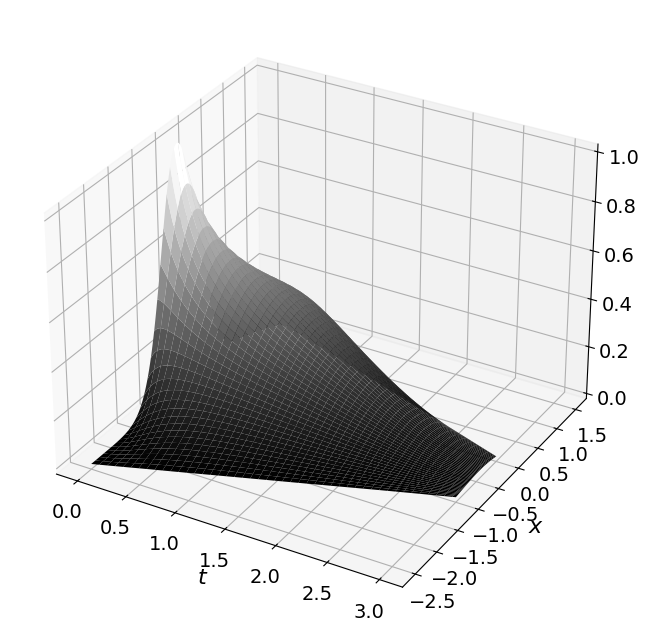

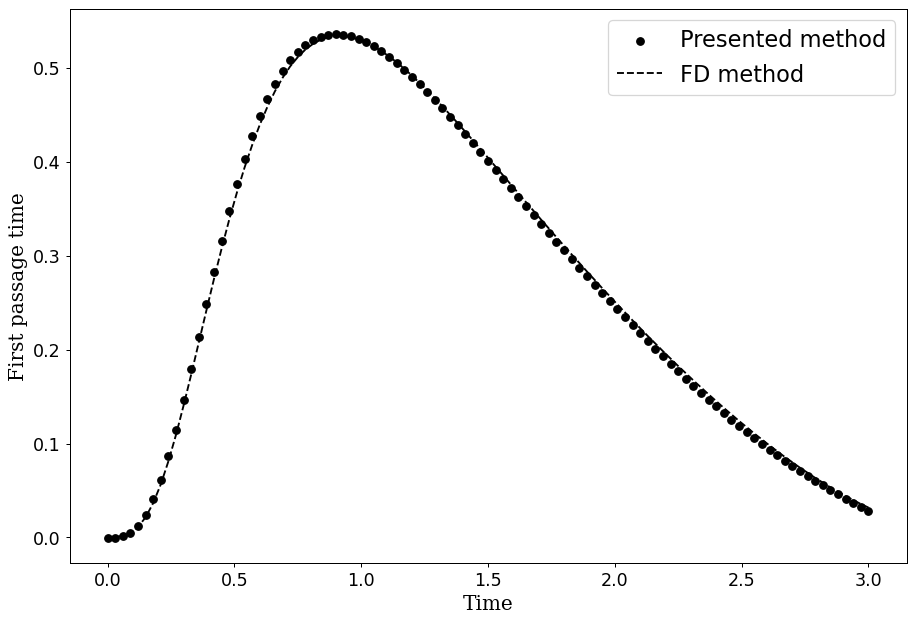

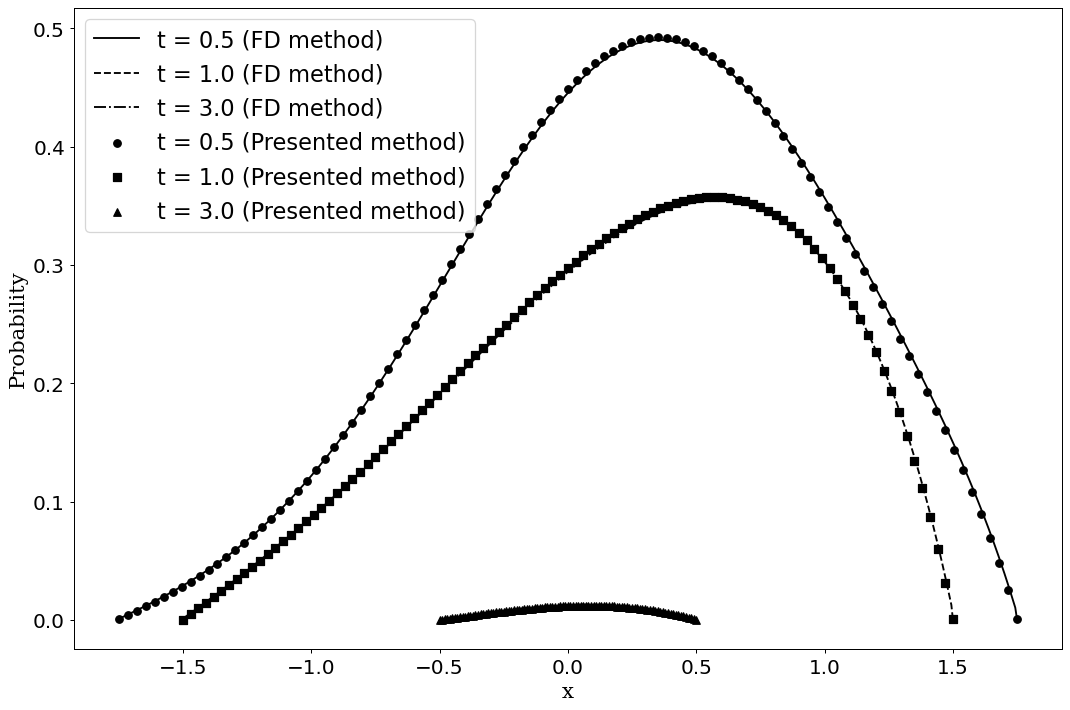

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from time import time
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)



delta = 7.8*10**(-2)

# direct’s delta function
def ddf(x,delta):
    return 1/(2*np.sqrt(np.pi*delta))*tf.math.exp(-((x-0.0)**2)/(4*delta))


PINN_J = []
FDM_J = []

T_INF= 2


# model parameters
sigma = 1.

# Define initial condition
def fun_u_0(x):
    return ddf(x,delta)

# Define boundary condition
def fun_u_b(t, x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)
a = 2
v = 0.7
def b(t):
  return 2 - 2*t/(2*T_inf)
def mu(x,t):
  return v/b(t) - (x*(-a/(2*T_inf)))/b(t)
# -
# Define residual of the PDE
def fun_r(t, x, u, u_t, u_x, u_xx):
    return u_t + mu(x,t)*u_x - 0.5*(sigma/b(t))**2 * u_xx



N_0 = 100
N_b = 200
N_r = 5000


# Set boundary
tmin = 0.
tmax = 3.
xmin = -1.
xmax = 1.

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]    #t = 0
x_0 = np.linspace(lb[1], ub[1], N_0-1, dtype=DTYPE)
x_0 = np.asarray(list(x_0) + [0.0])
x_0 =tf.convert_to_tensor(x_0, dtype=DTYPE)
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)



x_0 = tf.convert_to_tensor(x_0,dtype=DTYPE)
x_0 = tf.reshape(x_0 ,[N_0,1])
u_0 = fun_u_0(x_0*2)

#plt.plot(x_0, u_0 , '*')
X_0 = tf.concat([t_0, x_0], axis=1)

# Boundary data
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b = tf.concat([t_b, x_b], axis=1)

# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(t_b, x_b)

# Draw uniformly sampled collocation points
#t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
#x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_0, X_b]
u_data = [u_0, u_b]




#from keras.src.layers.core.activation import Activation
def Model(num_hidden_layers=3, num_neurons_per_layer=30):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(shape=(2,)))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
              lambda x: ((x - lb[1])/(ub[1] - lb[1]) * (ub[1]-lb[1])) + lb[1])

    #model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers-1):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))
    model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation='softmax'))
    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))

    return model

def get_r(model, X_r):

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x = X_r[:, 0:1], X_r[:,1:2]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x and u_xx
        tape.watch(t)
        tape.watch(x)

        # Determine residual
        u = model(tf.stack([t[:,0], x[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_x = tape.gradient(u, x)

    u_t = tape.gradient(u, t)
    u_xx = tape.gradient(u_x, x)

    return fun_r(t, x, u, u_t, u_x, u_xx)


def compute_loss(model, X_r, X_data, u_data):

    # Compute phi^r
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))
    # Initialize loss
    loss1 = phi_r
    u_pred0 = model(X_data[0])
    loss2 = tf.reduce_mean(tf.square(u_data[0] - u_pred0))

    u_pred1 = model(X_data[1])
    loss3 = tf.reduce_mean(tf.square(u_data[1] - u_pred1))
    loss =  loss1 + loss2 + loss3
    return loss, loss1, loss2,loss3

def get_grad(model, X_r, X_data, u_data):

    with tf.GradientTape(persistent=False) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        #tape.watch(model.trainable_variables)
        loss,loss_pde, loss_ic, loss_bc = compute_loss(model, X_r, X_data, u_data)


    g = tape.gradient(loss, model.trainable_variables)
    del tape
    return loss, g, loss_pde, loss_ic, loss_bc

# Initialize model aka u_\theta
model = Model()

# We choose a piecewise decay of the learning rate, i.e., the

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,5000,20000],[1e-2,1e-3,5e-4,1e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)


# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta, loss_pde, loss_ic, loss_bc = get_grad(model, X_r, X_data, u_data)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss, loss_pde, loss_ic, loss_bc

# Number of training epochs
N = 50000
hist = []

hist_pde = []
hist_ic = []
hist_bc = []

# Start timer
t0 = time()

for i in range(N+1):

    loss, loss_pde, loss_ic, loss_bc = train_step()

    # Append current loss to hist
    hist.append(loss.numpy())
    hist_pde.append(loss_pde.numpy())
    hist_ic.append(loss_ic.numpy())
    hist_bc.append(loss_bc.numpy())
    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))


def be(rr):
  return 2 - 2*rr/(2*T_inf)

def mu(x,rr):
  r = v/be(rr)-(x*(-2/(2*T_inf)))/be(rr)
  return -r

import numpy as np
import matplotlib.pyplot as plt


def tridiag(a, b, c, k1=-1, k2=0, k3=1):
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)


# Parameters
L = 2         # Length of the domain
N = 500         # Number of spatial points
T = 3          # Total time
dt = 0.03       # Time step

# Time-dependent diffusion coefficient function

delta = 7.8*10**(-2)


# Spatial grid
x = np.linspace(-1, 1, N)
dx = x[1] - x[0]

# Initial condition: Gaussian distribution
P = 1/(2*np.sqrt(np.pi*delta))*np.exp(-((2*x-0.)**2)/(4*delta))

# Time evolution
timesteps = int(T / dt)
P_all = np.zeros((N,timesteps+1))
P_all[:,0] = P
for t in range(timesteps):
    P_new = np.zeros_like(P)
    tt = (t)*dt
    # Get the current time-dependent diffusion coefficient
    #D_current = D(t * dt)
    a = (-(dt/(4*dx**2))*(sigma/be(tt))**2+(mu(x[1:],tt)*dt)/(4*dx))*np.ones((N-1))
    b = (1+((dt/(2*dx**2)))*(sigma/be(tt))**2)*np.ones((N))
    c = (-(dt/(4*dx**2))*(sigma/be(tt))**2-(mu(x[:-1],tt)*dt)/(4*dx))*np.ones((N-1))
    A = tridiag(a, b, c)


    aa = ((dt/(4*dx**2))*(sigma/be(tt))**2-(mu(x[1:],tt)*dt)/(4*dx))*np.ones((N-1))
    bb = (1-((dt/(2*dx**2)))*(sigma/be(tt))**2)*np.ones((N))
    cc = ((dt/(4*dx**2))*(sigma/be(tt))**2+(mu(x[:-1],tt)*dt)/(4*dx))*np.ones((N-1))
    B = tridiag(aa, bb, cc)
    # Finite difference scheme
    P_new = np.linalg.inv(A) @ B @ P

    P_new[0] = 0
    P_new[-1] = 0

    P = P_new
    P_all[:,t+1] = P

N = 100

tspace = np.linspace(0, ub[0], N + 1)
xspace = np.ones((N+1))*ub[1]
X = np.zeros((N+1,2))
X[:,0] = tspace
X[:,1] = xspace
X = tf.constant(X,DTYPE)
p_i =  model(X)

xspace1 = np.ones((N+1))*(ub[1]-0.02)
X1 = np.zeros((N+1,2))
X1[:,0] = tspace
X1[:,1] = xspace1
X1 = tf.constant(X1,DTYPE)
p_ii =  model(X1)

xspace2 = np.ones((N+1))*(ub[1]-0.04)
X2 = np.zeros((N+1,2))
X2[:,0] = tspace
X2[:,1] = xspace2
X2 = tf.constant(X2,DTYPE)
p_iii =  model(X2)
def b(t):
  return 2 - 2*t/(2*T_inf)
ddx = xspace*b(tspace) - xspace1*b(tspace)
ddx_j = tf.reshape(ddx,[N+1,1])
p_x = (3*p_i-4*p_ii+p_iii)/(2*ddx_j)
J1 = mu(np.reshape(xspace,(N+1,1)),tspace.reshape((N+1,1)))* p_i -0.5*sigma**2*p_x



p_x_fd = (3*P_all[-1,:]-4*P_all[-2,:]+P_all[-3,:])/(ddx)
J1_fd = mu(np.reshape(xspace,(1,N+1)),tspace.reshape((1,N+1)))* P_all[-1,:] -0.5*sigma**2*p_x_fd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Set up meshgrid
N = 500
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(), X.flatten()]).T

upred = model(tf.cast(Xgrid, DTYPE))


U = upred.numpy().reshape(N+1, N+1)


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# سیاه و سفید
surf = ax.plot_surface(T, X*b(T)-0.5, U, cmap='gray')


ax.set_xlabel('$t$', fontsize=16)
ax.set_ylabel('$x$', fontsize=16)


ax.tick_params(axis='both', which='major', labelsize=14)


plt.savefig("ex5-1.pdf", format="pdf", bbox_inches="tight")

plt.show()


import matplotlib.pyplot as plt
import numpy as np
N = 100

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

plt.figure(figsize=(12, 8), dpi=90)
tspace = np.linspace(lb[0], ub[0], N + 1)

plt.scatter(tspace, J1, label='Presented method',
            color='black', marker='o')


J1_fd_np = J1_fd.numpy().reshape((N+1,))

plt.plot(tspace, J1_fd_np,
         label='FD method',
         color='black', linestyle='--')


plt.xlabel('Time', fontdict=font)
plt.ylabel('First passage time', fontdict=font)


plt.legend(fontsize=18)


plt.tick_params(axis='both', which='major', labelsize=14)


plt.savefig("ex5-4.pdf", format="pdf", bbox_inches="tight")
plt.show()


import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 17,
        }

plt.figure(figsize=(12, 8), dpi=90)


plt.plot(x*b(0.5), P_all[:, 17], label='t = 0.5 (FD method)',
         color='black', linestyle='-')
plt.plot(x*b(1.0), P_all[:, 34], label='t = 1.0 (FD method)',
         color='black', linestyle='--')
plt.plot(x*b(3.0), P_all[:, -1], label='t = 3.0 (FD method)',
         color='black', linestyle='-.')


t_list = [0.5, 1.0, 3.0]
labels = ['t = 0.5 (Presented method)',
          't = 1.0 (Presented method)',
          't = 3.0 (Presented method)']
markers = ['o', 's', '^']

for tspace, label, marker in zip(t_list, labels, markers):
    N = 100
    xspace = np.linspace(lb[1], ub[1], N + 1)
    T, X = np.meshgrid(tspace, xspace)
    Xgrid = np.vstack([T.flatten(), X.flatten()]).T


    upred = model(tf.cast(Xgrid, DTYPE)).numpy()


    plt.scatter(X*b(tspace), upred, label=label,
                color='black', marker=marker)


plt.xlabel('x', fontdict=font)
plt.ylabel('Probability', fontdict=font)


plt.legend(fontsize=18)


plt.tick_params(axis='both', labelsize=16)

plt.tight_layout()
plt.savefig("ex5-2.pdf", format="pdf", bbox_inches="tight")
plt.show()



